## Import Libraries

In [93]:

import os
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

## Create Train and Test DF

In [4]:

#ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants'
ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants'
TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')


In [5]:

# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df


In [6]:
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

KeyError: 'is_fitara'

## EDA

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [7]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

In [8]:
pd.read_csv(TRAIN_LABELS).isnull().sum()

solicitation_id                77
contract_award_number         824
document_name                   0
is_fitara                       0
contains_statement_of_work      0
dtype: int64

In [9]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [10]:
#set_no = get_set_from_word_list(train_df_temp)
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [11]:
def get_tf_idf(train_df, test_df):
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names() #pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()), X

In [12]:
#tokenized_words = [nltk.word_tokenize(words) for words in train_df_temp]
#words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

#vectorizer = CountVectorizer(stop_words='english')
#vectorizer.fit_transform(words_list)

#pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

## Ablation Experiment

In [13]:
train_df_no = train_df[train_df.is_fitara == 0]
train_df_yes = train_df[train_df.is_fitara == 1]

In [14]:
# Get 15% of total Records for Ablation
ablation = 0.15
train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation)]
train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation)]

In [15]:
train_df_ablation = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

X = train_df_ablation.drop(['is_fitara'], axis=1)
y = train_df_ablation['is_fitara']

X_train_split, X_test_split, y_train, y_test = train_test_split(X, y, test_size=0.25)
#get_tf_idf(train_df_ablation['text'])
#train_df_ablation


In [16]:
X_train, X_test, feature_names = get_tf_idf(X_train_split['text'], X_test_split['text'])

In [90]:
%%time

model = SVC(kernel='linear', C=100, probability=True, random_state=0)

model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)



CPU times: user 94.2 ms, sys: 5.58 ms, total: 99.8 ms
Wall time: 99.2 ms


In [136]:
np.array([[1, x] for x in y_test])

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 1]])

In [134]:
# create model
model = Sequential()
model.add(Dense(35, input_dim=X_train.T.toarray().shape[0]))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# train model
history = model.fit(X_train.toarray(), y_t, epochs=400, batch_size=10, verbose=2)

# plot metrics
pyplot.plot(history.history['acc'])
pyplot.show()


Epoch 1/400
 - 1s - loss: 1.1284 - acc: 0.0833
Epoch 2/400
 - 0s - loss: 0.9528 - acc: 0.0833
Epoch 3/400
 - 0s - loss: 0.8088 - acc: 0.1389
Epoch 4/400
 - 0s - loss: 0.6845 - acc: 0.5417
Epoch 5/400
 - 0s - loss: 0.5927 - acc: 0.8333
Epoch 6/400
 - 0s - loss: 0.5257 - acc: 0.8889
Epoch 7/400
 - 0s - loss: 0.4760 - acc: 0.9167
Epoch 8/400
 - 0s - loss: 0.4381 - acc: 0.9167
Epoch 9/400
 - 0s - loss: 0.4112 - acc: 0.9167
Epoch 10/400
 - 0s - loss: 0.3884 - acc: 0.9167
Epoch 11/400
 - 0s - loss: 0.3720 - acc: 0.9167
Epoch 12/400
 - 0s - loss: 0.3564 - acc: 0.9167
Epoch 13/400
 - 0s - loss: 0.3443 - acc: 0.9167
Epoch 14/400
 - 0s - loss: 0.3328 - acc: 0.9167
Epoch 15/400
 - 0s - loss: 0.3215 - acc: 0.9167
Epoch 16/400
 - 0s - loss: 0.3107 - acc: 0.9167
Epoch 17/400
 - 0s - loss: 0.3007 - acc: 0.9167
Epoch 18/400
 - 0s - loss: 0.2908 - acc: 0.9167
Epoch 19/400
 - 0s - loss: 0.2823 - acc: 0.9167
Epoch 20/400
 - 0s - loss: 0.2743 - acc: 0.9167
Epoch 21/400
 - 0s - loss: 0.2670 - acc: 0.9167


Epoch 166/400
 - 0s - loss: 0.1234 - acc: 0.9167
Epoch 167/400
 - 0s - loss: 0.1233 - acc: 0.9167
Epoch 168/400
 - 0s - loss: 0.1232 - acc: 0.9167
Epoch 169/400
 - 0s - loss: 0.1231 - acc: 0.9167
Epoch 170/400
 - 0s - loss: 0.1230 - acc: 0.9167
Epoch 171/400
 - 0s - loss: 0.1229 - acc: 0.9167
Epoch 172/400
 - 0s - loss: 0.1228 - acc: 0.9167
Epoch 173/400
 - 0s - loss: 0.1227 - acc: 0.9167
Epoch 174/400
 - 0s - loss: 0.1226 - acc: 0.9167
Epoch 175/400
 - 0s - loss: 0.1225 - acc: 0.9167
Epoch 176/400
 - 0s - loss: 0.1224 - acc: 0.9167
Epoch 177/400
 - 0s - loss: 0.1223 - acc: 0.9167
Epoch 178/400
 - 0s - loss: 0.1223 - acc: 0.9167
Epoch 179/400
 - 0s - loss: 0.1222 - acc: 0.9167
Epoch 180/400
 - 0s - loss: 0.1221 - acc: 0.9167
Epoch 181/400
 - 0s - loss: 0.1220 - acc: 0.9167
Epoch 182/400
 - 0s - loss: 0.1219 - acc: 0.9167
Epoch 183/400
 - 0s - loss: 0.1219 - acc: 0.9167
Epoch 184/400
 - 0s - loss: 0.1218 - acc: 0.9167
Epoch 185/400
 - 0s - loss: 0.1217 - acc: 0.9167
Epoch 186/400
 - 0s 

KeyboardInterrupt: 

In [92]:
print(y_test.values)
print(pred)
#print(pred_proba)

num = metrics.log_loss(y_test.values, pred_proba)


math.exp(-num)


[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]


0.653460114513189

## Model Running

In [23]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.log_loss(y_test, pred)
    print("accuracy:   %0.3f" % score)
    """
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        #if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()
    """
    #if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred))

    #if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [24]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.009s
test time:  0.000s
accuracy:   4.317
classification report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        21
           1       0.00      0.00      0.00         3

    accuracy                           0.88        24
   macro avg       0.44      0.50      0.47        24
weighted avg       0.77      0.88      0.82        24

confusion matrix:
[[21  0]
 [ 3  0]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
     

/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.014s
test time:  0.000s
accuracy:   5.756
classification report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.00      0.00      0.00         3

    accuracy                           0.83        24
   macro avg       0.43      0.48      0.45        24
weighted avg       0.76      0.83      0.80        24

confusion matrix:
[[20  1]
 [ 3  0]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_interc

/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


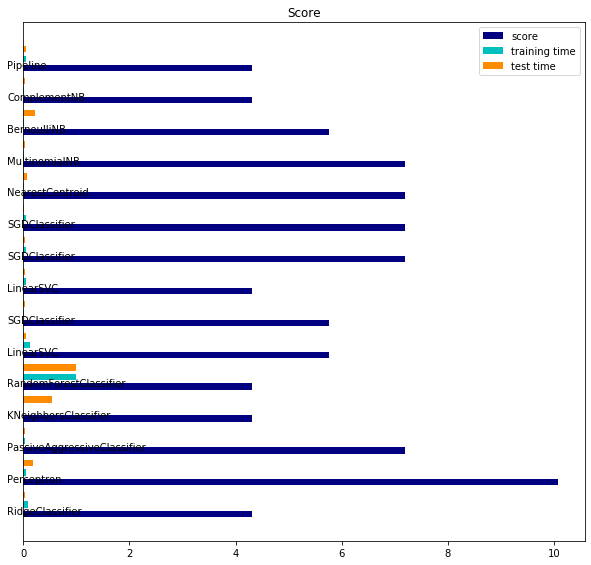

In [26]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()